# Imports

In [1]:
import os
from sys import path
path.append('../')

import numpy as np
import pandas as pd

import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers
from src.dataset import PneumoniaDetectionChallenge

# Dataset loading for training

In [2]:
DATASET_PATH = '../datasets/rsna-pneumonia-detection-challenge/'

In [3]:
pdc = PneumoniaDetectionChallenge(DATASET_PATH)
x_train, y_train, _ = pdc.load_train_data()

In [4]:
x_train = x_train / 255.0
x_train = x_train.reshape(-1, 256, 256, 1)

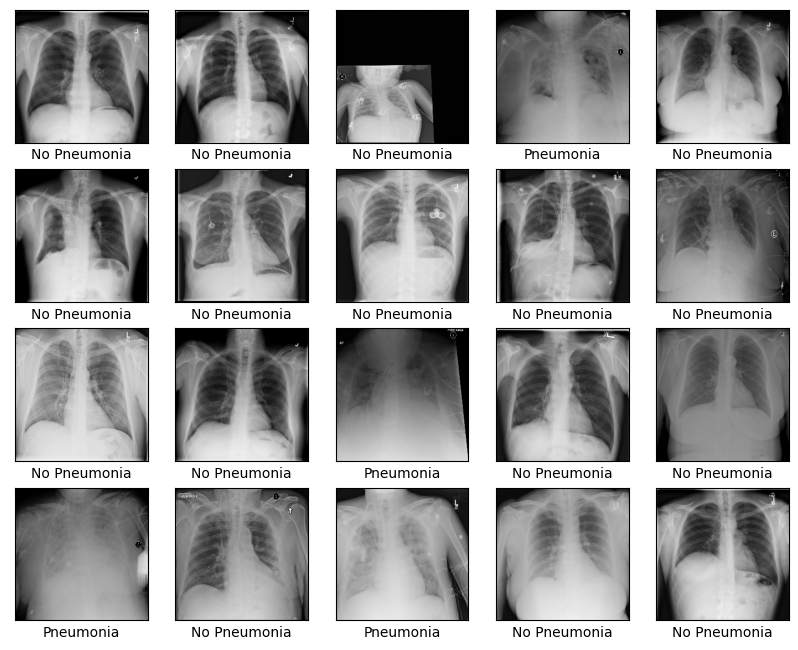

In [5]:
class_names = ['No Pneumonia', 'Pneumonia']

plt.figure(figsize=(10, 10))
for i in range(20):
    plt.subplot(5 ,5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap='gray')
    plt.xlabel(class_names[y_train[i]])
plt.show()

# Mdel definition

In [7]:
model = models.Sequential()
model.add(layers.Conv2D(filters=32, activation='relu', kernel_size=3, padding='same', input_shape=(256, 256, 1)))
model.add(layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))

model.add(layers.Conv2D(filters=64, activation="relu", kernel_size=3, padding="same"))
model.add(layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))

model.add(layers.Conv2D(filters=128, activation="relu", kernel_size=3, padding="same"))
model.add(layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))

model.add(layers.Conv2D(filters=128, activation="relu", kernel_size=3, padding="same"))
model.add(layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))

model.add(layers.Conv2D(filters=128, activation="relu", kernel_size=3, padding="same"))
model.add(layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 256, 256, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 128)      

In [8]:
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 256, 256, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 128)      

In [9]:
model.compile(optimizer='adam',
              loss="binary_crossentropy",
              metrics=["binary_accuracy"])

# Model training

In [10]:
history = model.fit(x_train, y_train, epochs=15)

Epoch 1/15
626/626 [==============================] - 36s 44ms/step - loss: 0.4714 - binary_accuracy: 0.7889
Epoch 2/15
626/626 [==============================] - 25s 41ms/step - loss: 0.4383 - binary_accuracy: 0.7984
Epoch 3/15
626/626 [==============================] - 26s 41ms/step - loss: 0.4239 - binary_accuracy: 0.8079
Epoch 4/15
626/626 [==============================] - 26s 42ms/step - loss: 0.4205 - binary_accuracy: 0.8110
Epoch 5/15
626/626 [==============================] - 26s 41ms/step - loss: 0.4163 - binary_accuracy: 0.8091
Epoch 6/15
626/626 [==============================] - 26s 41ms/step - loss: 0.4157 - binary_accuracy: 0.8088
Epoch 7/15
626/626 [==============================] - 26s 41ms/step - loss: 0.4054 - binary_accuracy: 0.8128
Epoch 8/15
626/626 [==============================] - 26s 41ms/step - loss: 0.4009 - binary_accuracy: 0.8172
Epoch 9/15
626/626 [==============================] - 25s 41ms/step - loss: 0.4007 - binary_accuracy: 0.8169
Epoch 10/15
626/626

In [11]:
del x_train
del y_train

# Evaluating the model

In [13]:
x_test, y_test, patients_id = pdc.load_test_data()
x_test = x_test / 255.0
x_test = x_test.reshape(-1, 256, 256, 1)

In [14]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)

209/209 [==============================] - 4s 17ms/step - loss: 0.4514 - binary_accuracy: 0.8012


In [15]:
predictions = model.predict(x_test)
predictions_rounded = np.round(predictions).astype(int)

In [16]:
test_labels_df = pdc.get_test_labels_df()

for patient_id, prediction in zip(patients_id, predictions_rounded):
    test_labels_df.loc[test_labels_df['patientId'] == patient_id, 'Prediction'] = prediction
test_labels_df.Prediction = test_labels_df.Prediction.astype(int)

In [17]:
hits = test_labels_df[test_labels_df['Target'] == test_labels_df['Prediction']].count()[1]
errors = test_labels_df[test_labels_df['Target'] != test_labels_df['Prediction']].count()[1]

In [18]:
print('General:')
print(' - Total:: ' + str(hits + errors))
print(' - Hits:: ' + str(hits))
print(' - Errors: ' + str(errors))
print(' - Hits ratio: ' + str(hits / (hits + errors)))

General:
 - Total:: 6671
 - Hits:: 5345
 - Errors: 1326
 - Hits ratio: 0.8012292010193375


In [19]:
hits = test_labels_df[(test_labels_df['Target'] == 0) & (test_labels_df['Target'] == test_labels_df['Prediction'])].count()[1]
errors = test_labels_df[(test_labels_df['Target'] == 0) & (test_labels_df['Target'] != test_labels_df['Prediction'])].count()[1]

In [20]:
print('No Pneumonia:')
print(' - Total: ' + str(hits + errors))
print(' - Hits: ' + str(hits))
print(' - Errors: ' + str(errors))
print(' - Hits ratio: ' + str(hits / (hits + errors)))

No Pneumonia:
 - Total: 5114
 - Hits: 4717
 - Errors: 397
 - Hits ratio: 0.9223699648025029


In [21]:
hits = test_labels_df[(test_labels_df['Target'] == 1) & (test_labels_df['Target'] == test_labels_df['Prediction'])].count()[1]
errors = test_labels_df[(test_labels_df['Target'] == 1) & (test_labels_df['Target'] != test_labels_df['Prediction'])].count()[1]

In [22]:
print('Pneumonia:')
print(' - Total: ' + str(hits + errors))
print(' - Hits: ' + str(hits))
print(' - Errors: ' + str(errors))
print(' - Hits ratio: ' + str(hits / (hits + errors)))

Pneumonia:
 - Total: 1557
 - Hits: 628
 - Errors: 929
 - Hits ratio: 0.40333975594091204
